In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(".", "transformers")))
from preprocessing_part_2 import * 
from column_selectors import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [2]:
new_train_df = pd.read_csv('dataframes/train_geo_clustered.csv')
new_val_df = pd.read_csv('dataframes/val_geo_clustered.csv')

*This dataframe is already split into train,val,test in Feature Engineering file and saved to csv*

In [3]:
# we have a train df with a new column from first clusterization
new_train_df.head(2)

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category,geo_cluster
0,Lead Handyman Services,25.324796,55.417346,-0.135231,1.061147,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,1,1,Service,0
1,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,-0.136699,1.061147,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Attorney,0


# Feature engineering part 2

We still have some columns to delete:
* name - is unique for every company
* latitude and longitude - these features were used for first clustering, now we have geo_cluster so we don't need them anymore
* Friday,...Sunday - We already have binary columns like monday_morning/monday_evening etc

Column that we have to encode: main category

In [4]:
pipes1 = Pipeline([('remove_more_cols',MoreColumnsRemover()), # removing irrelevant columns mentioned above
                   ('encoder', CategoryEncoder()),    # one hot encoding 'main'category' column
                   ('bool_encode', BooleanToNumericEncoder())]) 
train_df = pipes1.fit_transform(new_train_df)

<Axes: >

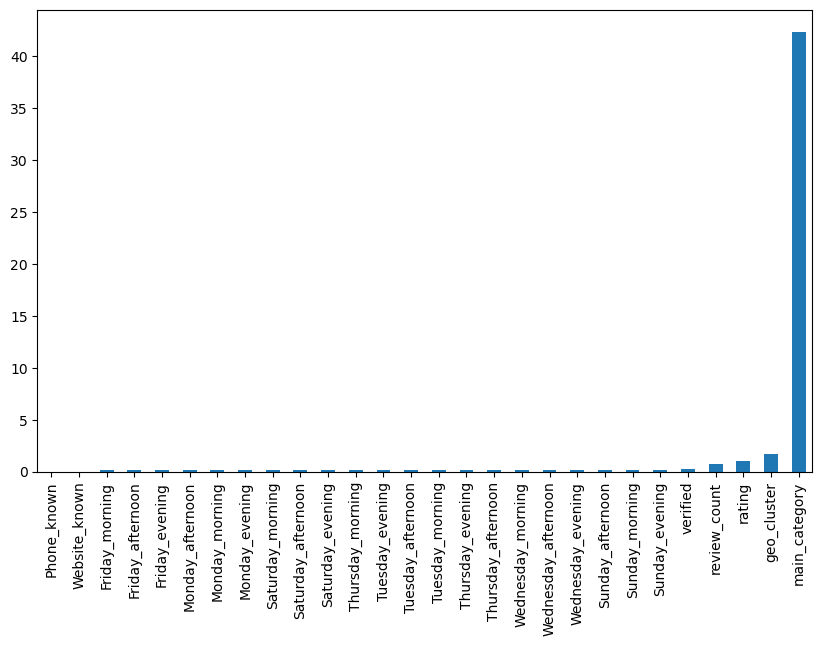

In [5]:
#check column's variances before standarization
variances = train_df.var()
sorted_variances = variances.sort_values()
plt.figure(figsize=(10, 6))
sorted_variances.plot(kind='bar')

In [6]:
print("Wariancje cech:\n", sorted_variances)

Wariancje cech:
 Phone_known             0.000000
Website_known           0.000000
Friday_morning          0.106481
Friday_afternoon        0.106481
Friday_evening          0.106481
Monday_afternoon        0.109538
Monday_morning          0.109538
Monday_evening          0.109538
Saturday_morning        0.109638
Saturday_afternoon      0.109638
Saturday_evening        0.109638
Thursday_morning        0.109688
Tuesday_evening         0.109688
Tuesday_afternoon       0.109688
Tuesday_morning         0.109688
Thursday_evening        0.109688
Thursday_afternoon      0.109688
Wednesday_morning       0.109787
Wednesday_afternoon     0.109787
Wednesday_evening       0.109787
Sunday_afternoon        0.111129
Sunday_morning          0.111129
Sunday_evening          0.111129
verified                0.208843
review_count            0.712063
rating                  0.970009
geo_cluster             1.718311
main_category          42.400658
dtype: float64


Variance analysis will help us with selecting the best dataframe to use in clustering.

We will create 3 selectors to select different subsets of columns in column_selector.py file.

## Feature selection

In [7]:
selector1 = Pipeline([('three_biggest_var', FirstColumnSelector())])
selector2 = Pipeline([('Variance_greater_than_015' ,SecondColumnSelector())])
selector3 = Pipeline([('Variance_greater_than_0', ThirdColumnSelector())])

train_df1 = selector1.fit_transform(train_df)
train_df2 = selector2.fit_transform(train_df)
train_df3 = selector3.fit_transform(train_df)

## Feature standardization

In [9]:
standardizer = Pipeline([('standardizer', SecondStandardizer())])

train_df1 = standardizer.fit_transform(train_df1)
train_df2 = standardizer.fit_transform(train_df2)
train_df3 = standardizer.fit_transform(train_df3)

In [10]:
train_df1

,geo_cluster,rating,review_count,main_category
0,-0.528633,1.012531,-0.116107,0.568061
1,-0.528633,1.012531,-0.117847,-2.349915
2,0.234260,-0.349834,0.120765,0.721638
3,-0.528633,0.255662,-0.085535,0.260905
4,-0.528633,0.861157,-0.082304,0.568061
...,...,...,...,...
15034,-0.528633,-1.863572,-0.045021,-0.814138
15035,2.522939,-0.198460,-0.065651,-1.582027
15036,2.522939,0.104288,-0.111385,0.568061
15037,0.234260,-1.712198,-0.107408,-2.042760


### At this point we have 3 dataframes to use. The most general one is train_df3 (we only removed columns with variance 0)

# PCA

In [33]:
#let's see if we can achieve little information loss with only 2 components
def print_explained_variance(df):
    pca = PCA(n_components=3)
    pca.fit(df)
    print(pca.explained_variance_ratio_)

In [34]:
print_explained_variance(train_df3)

[0.79093257 0.04791902 0.0401213 ]


Explained variance measures the proportion of variance in the data that is explained by each principal component. 

In [35]:
def print_optimal_components(df, trehslod):
    pca = PCA(trehslod)
    pca.fit(df)
    print(pca.n_components_)

In [37]:
print_optimal_components(train_df3, .85) # no point in checking for df1 and df2 as they have just a few columns

3


We need 3 components to keep 85% of info

In order to have 85% of the variance explained we need 21 components. Our dataframe has 50 so that is less than half of the features that we would need withou pca

# Model building and evaluation

First let's look at some evaluation metrics that we will use for chooseing the best model.
1. **Silhouuette Score** - how each point is similar to other points in it's cluster (form -1 to 1)
2. **Davies-Bouldin Index** - how a given cluster is similar to the next one (the higher the score the worse)
3. **minimal distance between clusters** - minimal distance between two points that are in different clusters (cluster separation)
4. **mean distance to the cluster center** - average distance between points in clusters and cluster center
5. **mean inclust distance** - How close are points to each other in one cluster?

Also let's create some custom metrics like small distances among cluster, good cluster separation and good representation by center

In [42]:
from scipy.spatial import distance
#functions from Lab9 for minimal distance between clusters and distance to center
def min_interclust_dist(df, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(df[cluster_i_idx], df[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [104]:
from sklearn.metrics import silhouette_score,davies_bouldin_score
def create_report(model, data):
    model.fit(data)
    labels = model.labels_

    silhouette = silhouette_score(data,labels)
    davies = davies_bouldin_score(data,labels)

    X = data.values

    min_interclust = min_interclust_dist(X,labels)
    mean_center = mean_dist_to_center(X,labels)
    mean_inclust = mean_inclust_dist(X,labels)

    result = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Min interclust distance', 'Mean distance to center','Inclust mean distance'],
        'Score': [silhouette, davies, min_interclust, mean_center,mean_inclust]
    })

    print(result)

In [62]:
from sklearn.metrics import silhouette_score,davies_bouldin_score
def create_report_for_PCA(model, X):
    model.fit(X)
    labels = model.labels_

    silhouette = silhouette_score(X,labels)
    davies = davies_bouldin_score(X,labels)


    min_interclust = min_interclust_dist(X,labels)
    mean_center = mean_dist_to_center(X,labels)
    mean_inclust = mean_inclust_dist(X,labels)

    result = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Min interclust distance', 'Mean distance to center','Inclust mean distance'],
        'Score': [silhouette, davies, min_interclust, mean_center,mean_inclust]
    })

    print(result)

# Model 1 - KMeans

In [44]:
#how many clusters should we use?
def print_elbows(data):
    inertia=[]
    for k in range (1,11):
        model = KMeans(n_clusters=k)
        model.fit(data) 
        inertia.append(model.inertia_)
    plt.figure(figsize=(8,6))
    plt.plot(range(1,11), inertia, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title("Elbow plot")
    plt.xticks(np.arange(1,11,1))
    plt.show()

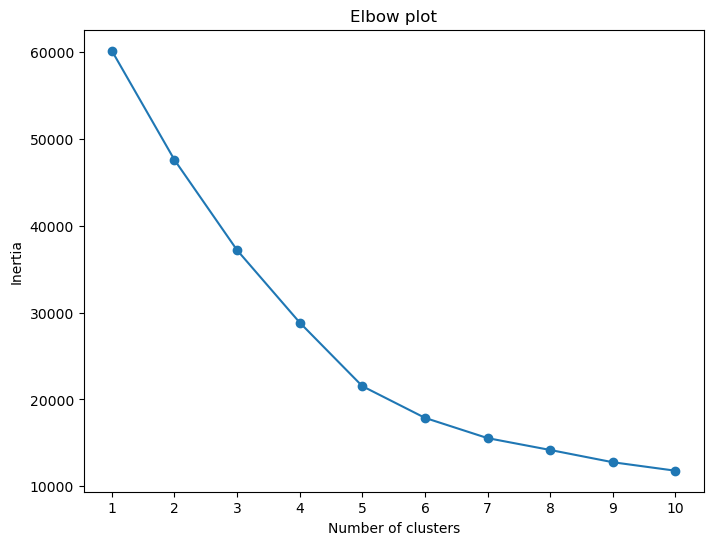

In [45]:
print_elbows(train_df1)

We can see the albow at 4-6 clusters for first df

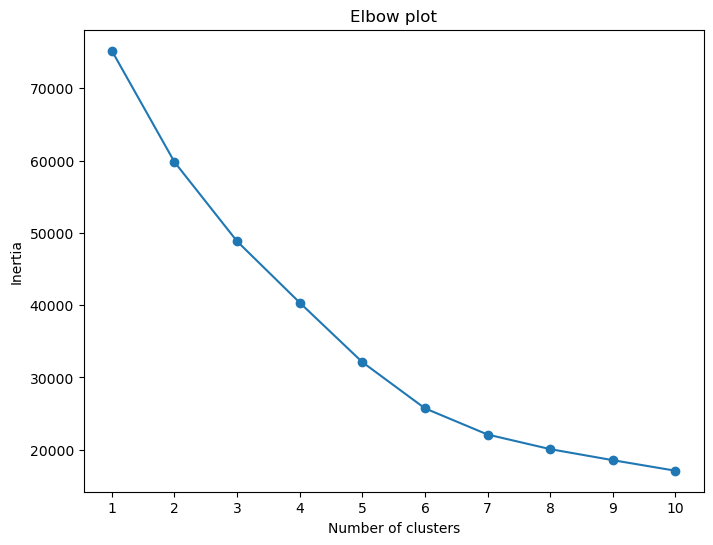

In [46]:
print_elbows(train_df2)

There is no obvious elbow for df2 but maybe around 6 or 9

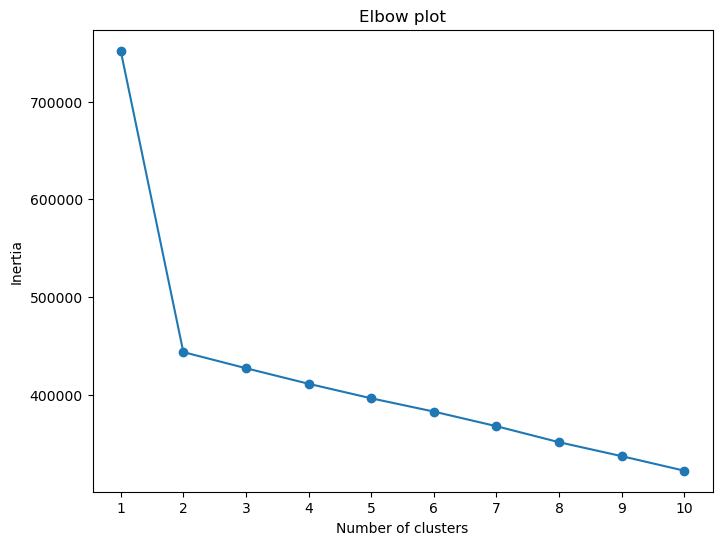

In [26]:
print_elbows(train_df3)

Here optimal number of clusters would be 2

In [47]:
model = KMeans(n_clusters=5)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.504224
1     Davies-Bouldin Score  0.754715
2  Min interclust distance  0.151374
3  Mean distance to center  2.766247
4    Inclust mean distance  3.783074


In [49]:
model=KMeans(n_clusters=6)
create_report(model, train_df2)

                    Metric     Score
0         Silhouette Score  0.463110
1     Davies-Bouldin Score  0.828715
2  Min interclust distance  0.151374
3  Mean distance to center  2.626854
4    Inclust mean distance  3.591501


In [50]:
model = KMeans(n_clusters=2)
create_report(model,train_df3)

                    Metric     Score
0         Silhouette Score  0.804249
1     Davies-Bouldin Score  0.282278
2  Min interclust distance  5.701534
3  Mean distance to center  1.928347
4    Inclust mean distance  2.781823


In [53]:
model = KMeans(n_clusters=3)
pca = PCA(0.85)
data= pca.fit_transform(train_df3)
create_report_for_PCA(model,data)

                    Metric     Score
0         Silhouette Score  0.436347
1     Davies-Bouldin Score  0.815094
2  Min interclust distance  0.004046
3  Mean distance to center  1.046824
4    Inclust mean distance  1.461524


Best results for train_df3 with PCA or train_df1. Let's try to tune parameters

In [53]:
param_grid={
    'n_clusters': range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300,400, 600]
}

model = KMeans()
reduced_df = pca.fit_transform(train_df3)
scoring = 'silhouette'
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='explained_variance')
grid_search.fit(reduced_df)

best_model = grid_search.best_estimator_

In [54]:
model = KMeans(n_clusters=2,n_init=10, max_iter=600)
pca = PCA(0.85)
create_report_for_PCA(model,pca.fit_transform(train_df3))

                    Metric     Score
0         Silhouette Score  0.874121
1     Davies-Bouldin Score  0.174206
2  Min interclust distance  2.114818
3  Mean distance to center  1.190049
4    Inclust mean distance  1.692866


**Observations**
1. We have the best silhuette score for KMeans with hyperparameters and PCA
2. KMeans with hyperparameters and PCA also has best results in minimal distance between clsuters >2

# DBSCAN - Density based

In [81]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer

def dbscan_silhouette_score(X, labels):
    # Jeżeli wszystkie punkty są zaklasyfikowane jako szum (label -1), zwróć wynik -1
    if len(set(labels)) <= 1:
        return -1
    else:
        return silhouette_score(X, labels)
    
param_grid = {
    'eps': np.linspace(0.1,15),
    'min_samples': np.arange(6,20,step=1)
}

dbscan= DBSCAN()
grid_search = GridSearchCV(dbscan, param_grid, scoring=make_scorer(dbscan_silhouette_score), cv=3, n_jobs=-1)

pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
grid_search.fit(reduced_df)

GridSearchCV(cv=3, estimator=DBSCAN(), n_jobs=-1,
             param_grid={'eps': array([ 0.1       ,  0.40408163,  0.70816327,  1.0122449 ,  1.31632653,
        1.62040816,  1.9244898 ,  2.22857143,  2.53265306,  2.83673469,
        3.14081633,  3.44489796,  3.74897959,  4.05306122,  4.35714286,
        4.66122449,  4.96530612,  5.26938776,  5.57346939,  5.87755102,
        6.18163265,  6.48571429,  6.78979592,  7.09387755,  7.39795918,
        7.70204082,  8...71,  8.91836735,
        9.22244898,  9.52653061,  9.83061224, 10.13469388, 10.43877551,
       10.74285714, 11.04693878, 11.35102041, 11.65510204, 11.95918367,
       12.26326531, 12.56734694, 12.87142857, 13.1755102 , 13.47959184,
       13.78367347, 14.0877551 , 14.39183673, 14.69591837, 15.        ]),
                         'min_samples': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring=make_scorer(dbscan_silhouette_score))

In [82]:
print(grid_search.best_params_)

{'eps': 0.1, 'min_samples': 6}


In [83]:
model = DBSCAN(eps=0.1, min_samples=6)
model.fit(reduced_df)
print(set(model.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, -1}


Grid Search results are not safisfying as they focus on best score and create too many clusters, so let's experiment

In [86]:
def dbscan_clusters(eps,min_s,dataframe):
    model = DBSCAN(eps=eps,min_samples=min_s)
    model.fit(dataframe)
    print(set(model.labels_))

In [91]:
dbscan_clusters(0.2,15,reduced_df)
create_report_for_PCA(DBSCAN(eps=0.2, min_samples=15), reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}
                    Metric     Score
0         Silhouette Score  0.156701
1     Davies-Bouldin Score  1.088130
2  Min interclust distance  0.074778
3  Mean distance to center  0.633382
4    Inclust mean distance  0.808172


While having a poor silhuette score, we have quite good distance to center and inclust distance

In [94]:
dbscan_clusters(0.17,12,reduced_df)
create_report_for_PCA(DBSCAN(eps=0.17, min_samples=12), reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1}
                    Metric     Score
0         Silhouette Score  0.109971
1     Davies-Bouldin Score  1.111190
2  Min interclust distance  0.020615
3  Mean distance to center  0.465892
4    Inclust mean distance  0.595231


In [99]:
dbscan_clusters(0.3,6,reduced_df)
create_report_for_PCA(DBSCAN(eps=0.3, min_samples=6), reduced_df)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}
                    Metric     Score
0         Silhouette Score  0.222641
1     Davies-Bouldin Score  1.135930
2  Min interclust distance  0.126368
3  Mean distance to center  0.555548
4    Inclust mean distance  0.752013


Let's try DBSCAN for df without PCA

In [105]:
dbscan_clusters(0.3,20,train_df1)
create_report(DBSCAN(eps=0.3,min_samples=20),train_df1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}
                    Metric     Score
0         Silhouette Score -0.092648
1     Davies-Bouldin Score  1.433913
2  Min interclust distance  0.004723
3  Mean distance to center  0.337746
4    Inclust mean distance  0.461669


Rather poor results

In [108]:
dbscan_clusters(0.5,20,train_df3)
create_report(DBSCAN(eps=0.5,min_samples=20),train_df3)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, -1}
                    Metric     Score
0         Silhouette Score  0.011304
1     Davies-Bouldin Score  1.401159
2  Min interclust distance  0.026347
3  Mean distance to center  0.650901
4    Inclust mean distance  0.879121


For DBSCAN results are also best for PCA reduced dataframe

# Agglomerative clustering -hierarchical

In [112]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering()
model.fit(train_df1)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.468152
1     Davies-Bouldin Score  1.116600
2  Min interclust distance  0.151394
3  Mean distance to center  1.498684
4    Inclust mean distance  2.133770


In [113]:
model=AgglomerativeClustering()
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.874054
1     Davies-Bouldin Score  0.173564
2  Min interclust distance  1.753212
3  Mean distance to center  1.186306
4    Inclust mean distance  1.687482


The best silhuette score so far. Let's experiment with parameters

In [118]:
model=AgglomerativeClustering(n_clusters=3)
pca = PCA(0.9)
reduced_df = pca.fit_transform(train_df3)
model.fit(reduced_df)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.445487
1     Davies-Bouldin Score  0.804481
2  Min interclust distance  0.115811
3  Mean distance to center  1.294142
4    Inclust mean distance  1.849250


After few changes the scores didn't improve

# Mean shift

In [119]:
from sklearn.cluster import MeanShift
model= MeanShift()
pca = PCA(0.85)
reduced_df = pca.fit_transform(train_df3)
create_report_for_PCA(model,reduced_df)

                    Metric     Score
0         Silhouette Score  0.732151
1     Davies-Bouldin Score  0.473396
2  Min interclust distance  0.099399
3  Mean distance to center  1.307765
4    Inclust mean distance       NaN


In [120]:
model=MeanShift(max_iter=400)
model.fit(train_df1)
create_report(model,train_df1)

                    Metric     Score
0         Silhouette Score  0.482758
1     Davies-Bouldin Score  0.687839
2  Min interclust distance  0.124029
3  Mean distance to center  0.685406
4    Inclust mean distance       NaN


For this df we have a smaller distance to center but worse silhuette